In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
from matplotlib.ticker import FuncFormatter

In [3]:
sns.set_style('darkgrid')
# palette = sns.color_palette('Accent', 10)
palette = sns.color_palette('Paired', 12)
sns.set_palette(palette)

## Humanoid

In [68]:
log_dirs_sb_sac = ['../data/SB_SAC_Humanoid-v5_06-06-2025_00-49-27_GOOD/SAC_1']
SB_SAC_TIME = 3 * 60 * 60  # 3 hours in seconds
log_dirs_custom_sac = ['../data/SAC_Humanoid-v5_06-06-2025_01-29-49_GOOD']
CUSTOM_SAC_TIME = 4 * 60 * 60  # 6 hours in seconds
log_dirs_sb_a2c = ['../data/SB_A2C_Humanoid-v5_08-06-2025_16-25-34_GOOD/A2C_1',
                   '../data/SB_A2C_Humanoid-v5_08-06-2025_17-06-02_GOOD/A2C_1']
SB_A2C_TIME = 25 * 60  # 25 minutes in seconds
log_dirs_custom_a2c = ['../data/A2C_Humanoid-v5_08-06-2025_17-06-59_GOOD',
                       '../data/A2C_Humanoid-v5_08-06-2025_19-17-38_GOOD']
CUSTOM_A2C_TIME = 25 * 60  # 25 minutes in seconds
BC_SCORE = 470
BC_SAMPLES = 999_434

### StableBaselines A2C

In [ ]:
df_sb_a2c = pd.DataFrame()
all_values = []
all_steps = []

for idx in range(len(log_dirs_sb_a2c)):
    ea = event_accumulator.EventAccumulator(log_dirs_sb_a2c[idx])
    ea.Reload()
    # Access scalar data
    for scalar_tag in ea.Tags()['scalars']:
        if scalar_tag not in ('rollout/ep_rew_mean'):
            continue
        scalar_events = ea.Scalars(scalar_tag)
        values = []
        steps = []
        for event in scalar_events:
            values.append(event.value)
            steps.append(event.step)
        all_values.append(values)
        all_steps.append(steps)

# Create a common step grid for interpolation
max_steps = max(max(steps) for steps in all_steps)
common_steps = np.arange(100000, max_steps + 1, 100000)  # Every 100k steps

# Interpolate each run to common steps
interpolated_values = []
for i in range(len(all_values)):
    interpolated = np.interp(common_steps, all_steps[i], all_values[i])
    df_sb_a2c[f'eval_return_{i}'] = interpolated
    interpolated_values.append(interpolated)

df_sb_a2c['steps'] = common_steps

# Calculate mean across the two runs
df_sb_a2c['eval_return_mean'] = df_sb_a2c[[f'eval_return_{i}' for i in range(len(log_dirs_sb_a2c))]].mean(axis=1)
df_sb_a2c['eval_return_roll'] = df_sb_a2c['eval_return_mean'].rolling(10).mean()
df_sb_a2c['time_taken'] = np.linspace(0, SB_A2C_TIME, len(df_sb_a2c))
df_sb_a2c['name'] = 'Stable-Baselines3 A2C'


### Custom A2C

In [70]:
df_custom_a2c = pd.DataFrame()
all_values = []
all_steps = []

for idx in range(len(log_dirs_custom_a2c)):
    ea = event_accumulator.EventAccumulator(log_dirs_custom_a2c[idx])
    ea.Reload()
    # Access scalar data
    for scalar_tag in ea.Tags()['scalars']:
        if scalar_tag not in ('eval_return'):
            continue
        scalar_events = ea.Scalars(scalar_tag)
        values = []
        steps = []
        for event in scalar_events:
            values.append(event.value)
            steps.append(event.step)
        all_values.append(values)
        all_steps.append(steps)

# Create a common step grid for interpolation
max_steps = max(max(steps) for steps in all_steps)
common_steps = np.arange(100000, max_steps + 1, 100000)  # Every 100k steps

# Interpolate each run to common steps
interpolated_values = []
for i in range(len(all_values)):
    interpolated = np.interp(common_steps, all_steps[i], all_values[i])
    df_custom_a2c[f'eval_return_{i}'] = interpolated
    interpolated_values.append(interpolated)

df_custom_a2c['steps'] = common_steps
# Remove rows where steps > 5000000
df_custom_a2c = df_custom_a2c[df_custom_a2c['steps'] <= 5000000]

# Calculate mean across the two runs
df_custom_a2c['eval_return_mean'] = df_custom_a2c[[f'eval_return_{i}' for i in range(len(log_dirs_sb_a2c))]].mean(axis=1)
df_custom_a2c['eval_return_roll'] = df_custom_a2c['eval_return_mean'].rolling(10).mean()
df_custom_a2c['time_taken'] = np.linspace(0, CUSTOM_A2C_TIME, len(df_custom_a2c))
df_custom_a2c['name'] = 'Custom A2C'


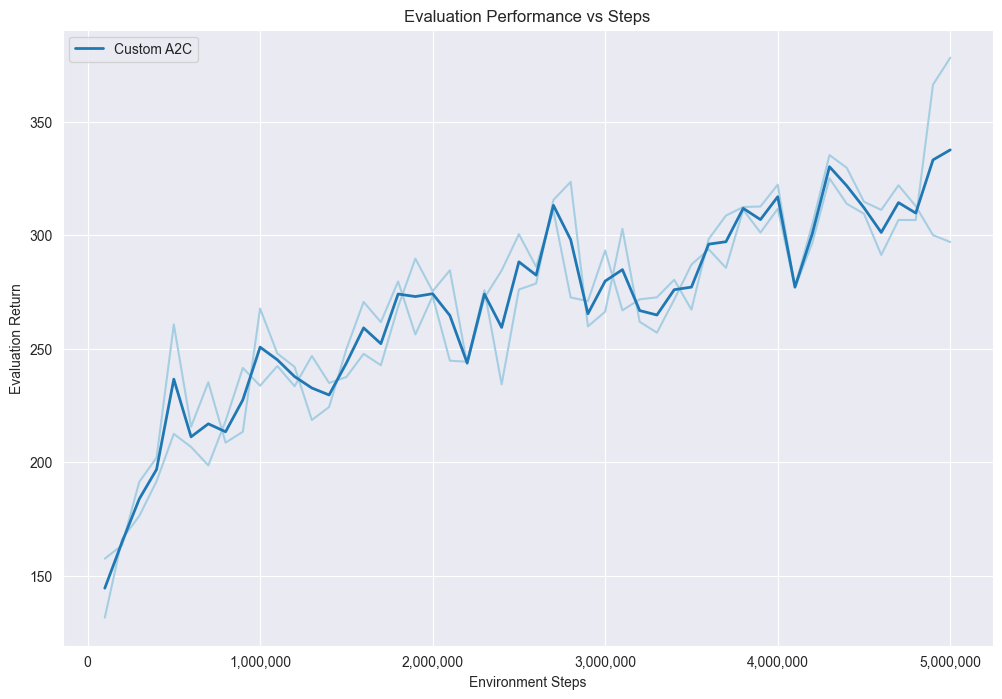

In [71]:
# palette = sns.color_palette('Accent', 10)
palette = sns.color_palette('Paired', 12)

# Create x-axis values scaled by eval_period for plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
c_idx = 0
# df = df_sb_a2c
df = df_custom_a2c
ax.plot(df['steps'], df['eval_return_0'], linewidth=1.5, color=palette[c_idx])
ax.plot(df['steps'], df['eval_return_1'], linewidth=1.5, color=palette[c_idx])
c_idx += 1
ax.plot(df['steps'], df['eval_return_mean'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}")

ax.set_xlabel('Environment Steps')
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Evaluation Return')
ax.set_title('Evaluation Performance vs Steps')
ax.legend()

# plt.savefig('humanoid.png', dpi=200, pad_inches=0, bbox_inches='tight')

### StableBaselines SAC

In [72]:
df_sb_sac = pd.DataFrame()

ea = event_accumulator.EventAccumulator(log_dirs_sb_sac[0])
ea.Reload()
# Access scalar data
for scalar_tag in ea.Tags()['scalars']:
    if scalar_tag not in ('rollout/ep_rew_mean'):
        continue
    scalar_events = ea.Scalars(scalar_tag)
    values = []
    steps = []
    for event in scalar_events:
        values.append(event.value)
        steps.append(event.step)
    df_sb_sac['eval_return'] = values
    df_sb_sac['steps'] = steps

df_sb_sac['time_taken'] = np.linspace(0, SB_SAC_TIME, len(df_sb_sac))
df_sb_sac['name'] = 'Stable-Baselines3 SAC'


### Custom SAC

In [73]:
df_custom_sac = pd.DataFrame()

ea = event_accumulator.EventAccumulator(log_dirs_custom_sac[0])
ea.Reload()
# Access scalar data
for scalar_tag in ea.Tags()['scalars']:
    if scalar_tag not in ('eval_return'):
        continue
    scalar_events = ea.Scalars(scalar_tag)
    values = []
    steps = []
    for event in scalar_events:
        values.append(event.value)
        steps.append(event.step)
    df_custom_sac['eval_return'] = values
    df_custom_sac['steps'] = steps
    df_custom_sac['eval_return_roll'] = df_custom_sac['eval_return'].rolling(10).mean()

df_custom_sac['time_taken'] = np.linspace(0, CUSTOM_SAC_TIME, len(df_custom_sac))
df_custom_sac['name'] = 'Custom SAC'


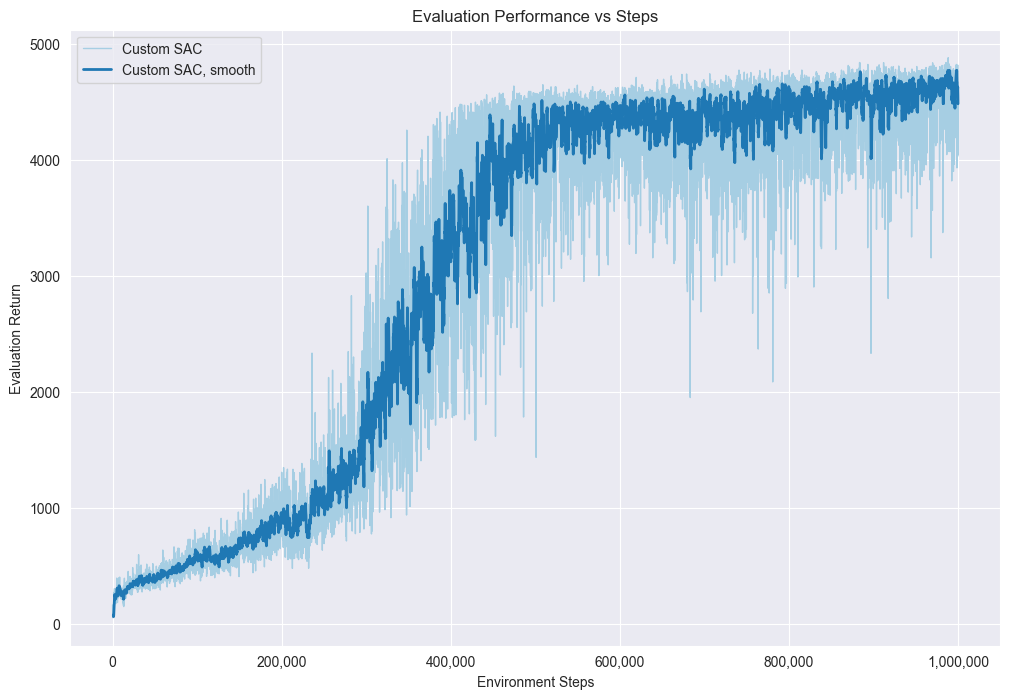

In [74]:
# palette = sns.color_palette('Accent', 10)
palette = sns.color_palette('Paired', 12)

# Create x-axis values scaled by eval_period for plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
c_idx = 0
# df = df_sb_sac
df = df_custom_sac
ax.plot(df['steps'], df['eval_return'], linewidth=1, color=palette[c_idx],
        label=f"{df['name'][0]}")
c_idx += 1
ax.plot(df['steps'], df['eval_return_roll'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, smooth")

ax.set_xlabel('Environment Steps')
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Evaluation Return')
ax.set_title('Evaluation Performance vs Steps')
ax.legend()

# plt.savefig('humanoid.png', dpi=200, pad_inches=0, bbox_inches='tight')

## Final plot

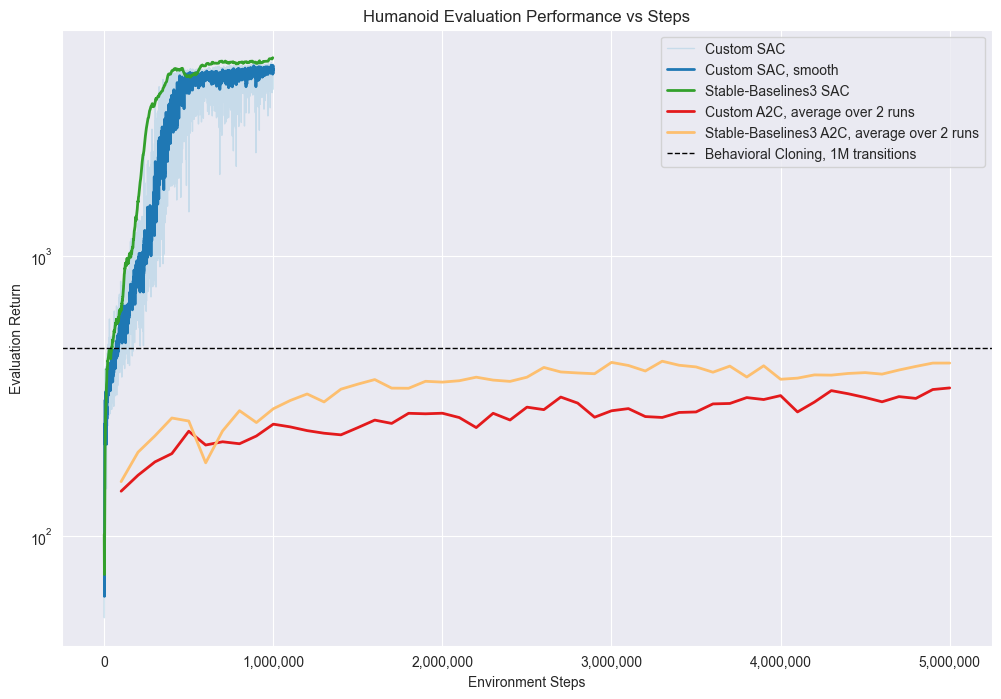

In [78]:
# palette = sns.color_palette('Accent', 10)
palette = sns.color_palette('Paired', 12)

# Create x-axis values scaled by eval_period for plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
c_idx = 0
df = df_custom_sac
ax.plot(df['steps'], df['eval_return'], linewidth=1, color=palette[c_idx],
        label=f"{df['name'][0]}", alpha=0.5)
c_idx += 1
ax.plot(df['steps'], df['eval_return_roll'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, smooth")

c_idx += 2
df = df_sb_sac
ax.plot(df['steps'], df['eval_return'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}")
c_idx += 2

df = df_custom_a2c
# ax.plot(df['steps'], df['eval_return_0'], linewidth=1, color=palette[c_idx], alpha=0.5)
# ax.plot(df['steps'], df['eval_return_1'], linewidth=1, color=palette[c_idx], alpha=0.5)
# c_idx += 1
ax.plot(df['steps'], df['eval_return_mean'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, average over 2 runs")

df = df_sb_a2c
# ax.plot(df['steps'], df['eval_return_0'], linewidth=1, color=palette[c_idx], alpha=0.5)
# ax.plot(df['steps'], df['eval_return_1'], linewidth=1, color=palette[c_idx], alpha=0.5)
c_idx += 1
ax.plot(df['steps'], df['eval_return_mean'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, average over 2 runs")

ax.axhline(BC_SCORE, color='black', linestyle='--', linewidth=1, label='Behavioral Cloning, 1M transitions')

ax.set_yscale('log')
ax.set_xlabel('Environment Steps')
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Evaluation Return')
ax.set_title('Humanoid Evaluation Performance vs Steps')
ax.legend()

plt.savefig('humanoid_env_steps.png', dpi=200, pad_inches=0.1, bbox_inches='tight')

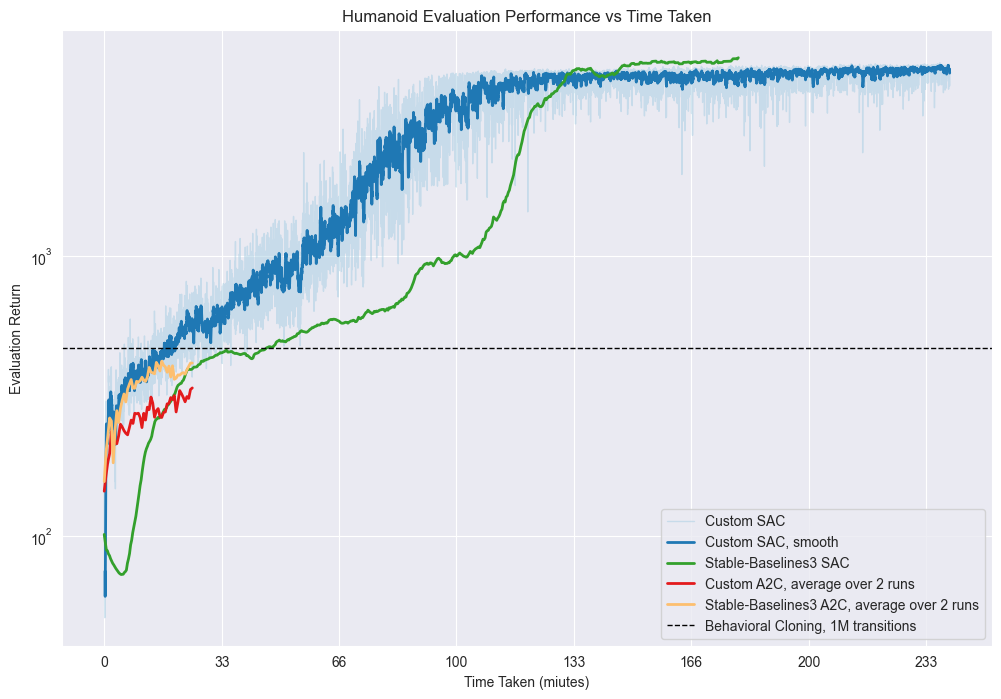

In [79]:
# palette = sns.color_palette('Accent', 10)
palette = sns.color_palette('Paired', 12)

# Create x-axis values scaled by eval_period for plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
c_idx = 0
df = df_custom_sac
ax.plot(df['time_taken'], df['eval_return'], linewidth=1, color=palette[c_idx],
        label=f"{df['name'][0]}", alpha=0.5)
c_idx += 1
ax.plot(df['time_taken'], df['eval_return_roll'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, smooth")

c_idx += 2
df = df_sb_sac
ax.plot(df['time_taken'], df['eval_return'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}")
c_idx += 2

df = df_custom_a2c
# ax.plot(df['steps'], df['eval_return_0'], linewidth=1, color=palette[c_idx], alpha=0.5)
# ax.plot(df['steps'], df['eval_return_1'], linewidth=1, color=palette[c_idx], alpha=0.5)
# c_idx += 1
ax.plot(df['time_taken'], df['eval_return_mean'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, average over 2 runs")

df = df_sb_a2c
# ax.plot(df['steps'], df['eval_return_0'], linewidth=1, color=palette[c_idx], alpha=0.5)
# ax.plot(df['steps'], df['eval_return_1'], linewidth=1, color=palette[c_idx], alpha=0.5)
c_idx += 1
ax.plot(df['time_taken'], df['eval_return_mean'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, average over 2 runs")

ax.axhline(BC_SCORE, color='black', linestyle='--', linewidth=1, label='Behavioral Cloning, 1M transitions')

ax.set_yscale('log')
ax.set_xlabel('Time Taken (miutes)')
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x / 60), ',')))
ax.set_ylabel('Evaluation Return')
ax.set_title('Humanoid Evaluation Performance vs Time Taken')
ax.legend()

plt.savefig('humanoid_time.png', dpi=200, pad_inches=0.1, bbox_inches='tight')